<a href="https://colab.research.google.com/github/alyymohamedd/projects/blob/main/Face_verification_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### **Face verification VS Face recognition**
**Face Verification:** answer the following question **"Is this claimed Person?"**

**Face Verification:** answer the following question **"Who is this Person?"**

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import PIL

###  Using a ConvNet to Compute Encodings

The FaceNet model takes a lot of data and a long time to train. So following the common practice in applied deep learning, you'll load weights that someone else has already trained. The network architecture follows the Inception model from [Szegedy *et al*..](https://arxiv.org/abs/1409.4842)


**The key things to be aware of are:**
- This network uses 160x160 dimensional RGB images as its input. Specifically, a face image (or batch of $m$ face images) as a tensor of shape $(m, n_H, n_W, n_C) = (m, 160, 160, 3)$
- The input images are originally of shape 96x96, thus, you need to scale them to 160x160. This is done in the `img_to_encoding()` function.
- The output is a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

In [12]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load pre-trained ResNetV2 model
base_model = ResNet50V2(weights='imagenet', include_top=False)

# Add GlobalAveragePooling2D layer to obtain fixed-size output
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a Dense layer with 128 units for encoded features
encoded_features = Dense(128)(x)

# Create a new model with the modified architecture
face_net_model = Model(inputs=base_model.input, outputs=encoded_features)

# Display model summary
face_net_model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, None, None, 64)       0         ['conv1_conv[0][0]']          
                             

In [13]:
print(face_net_model.inputs)
print(face_net_model.outputs)


[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense')>]


### **Define encoding function**
The function takes image path and model as input and return its encoding

---



In [61]:
def img_to_encoding(image_path, model):
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
  img = np.around(np.array(img) / 255.0, decimals=12)
  x_train = np.expand_dims(img, axis=0)
  embedding = model.predict_on_batch(x_train)
  return embedding / np.linalg.norm(embedding, ord=2)

### **Get the Dataset and precompute them:**

Instead of computing the database features each time, precompute the database encodings and save them. This way, you only need to compute the encoding of a new image.

In [68]:
database = {}
database["danielle"] = img_to_encoding("/content/gdrive/MyDrive/ML_Project/verification_data/images/danielle.png", face_net_model)
database["younes"] = img_to_encoding("/content/gdrive/MyDrive/ML_Project/verification_data/images/younes.jpg", face_net_model)
database["tian"] = img_to_encoding("/content/gdrive/MyDrive/ML_Project/verification_data/images/tian.jpg", face_net_model)
database["andrew"] = img_to_encoding("/content/gdrive/MyDrive/ML_Project/verification_data/images/andrew.jpg", face_net_model)
database["kian"] = img_to_encoding("/content/gdrive/MyDrive/ML_Project/verification_data/images/kian.jpg", face_net_model)
database["dan"] = img_to_encoding("/content/gdrive/MyDrive/ML_Project/verification_data/images/dan.jpg", face_net_model)
database["sebastiano"] = img_to_encoding("/content/gdrive/MyDrive/ML_Project/verification_data/images/sebastiano.jpg", face_net_model)
database["bertrand"] = img_to_encoding("/content/gdrive/MyDrive/ML_Project/verification_data/images/bertrand.jpg", face_net_model)
database["kevin"] = img_to_encoding("/content/gdrive/MyDrive/ML_Project/verification_data/images/kevin.jpg", face_net_model)
database["felix"] = img_to_encoding("/content/gdrive/MyDrive/ML_Project/verification_data/images/felix.jpg", face_net_model)
database["benoit"] = img_to_encoding("/content/gdrive/MyDrive/ML_Project/verification_data/images/benoit.jpg", face_net_model)
database["arnaud"] = img_to_encoding("/content/gdrive/MyDrive/ML_Project/verification_data/images/arnaud.jpg", face_net_model)

In [70]:
danielle = tf.keras.preprocessing.image.load_img("/content/gdrive/MyDrive/ML_Project/verification_data/images/danielle.png", target_size=(160, 160))
younes = tf.keras.preprocessing.image.load_img("/content/gdrive/MyDrive/ML_Project/verification_data/images/younes.jpg", target_size=(160, 160))
Kian = tf.keras.preprocessing.image.load_img("/content/gdrive/MyDrive/ML_Project/verification_data/images/kian.jpg", target_size=(160, 160))

In [71]:
np.around(np.array(danielle)/255.0, decimals=12).shape

(160, 160, 3)

check images

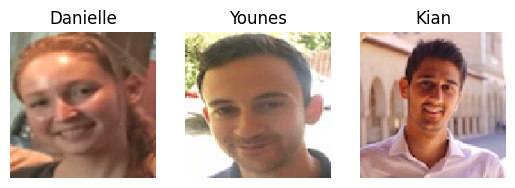

In [74]:
import matplotlib.pyplot as plt

plt.subplot(1, 3, 1)
plt.imshow(danielle)
plt.title("Danielle")
plt.axis('off')

# Plot the second image
plt.subplot(1, 3, 2)
plt.imshow(younes)
plt.title("Younes")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Kian)
plt.title("Kian")
plt.axis('off')

plt.show()

### **Define a Verification Function**

In [76]:
def verify(image_path, identity, database, model):

    encoding = img_to_encoding(image_path, model)
    dist = np.linalg.norm(encoding - database[identity], ord=2)
    if dist<0.7:
        print("It's " + str(identity) + ", welcome in!")
    else:
        print("It's not " + str(identity) + ", please go away")

    return dist

### **Let's Test the Model**

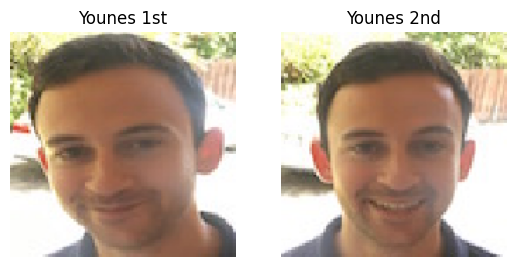

In [75]:
# plot younes pictures
younes2 = tf.keras.preprocessing.image.load_img("/content/gdrive/MyDrive/ML_Project/verification_data/images/camera_0.jpg", target_size=(160, 160))

plt.subplot(1, 2, 1)
plt.imshow(younes)
plt.title("Younes 1st")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(younes2)
plt.title("Younes 2nd")
plt.axis('off')

plt.show()

In [78]:
distance = verify("/content/gdrive/MyDrive/ML_Project/verification_data/images/camera_0.jpg", "younes", database, face_net_model)
print(distance)

It's younes, welcome in!
0.3278598


### Now lets try use 2 different photos

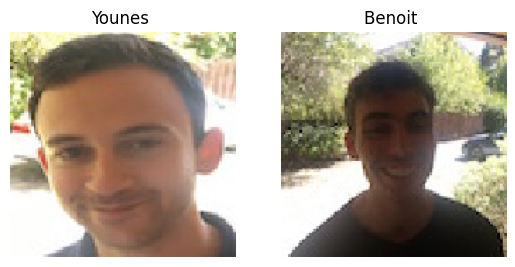

In [79]:
# plot younes pictures
benoit = tf.keras.preprocessing.image.load_img("/content/gdrive/MyDrive/ML_Project/verification_data/images/camera_2.jpg", target_size=(160, 160))

plt.subplot(1, 2, 1)
plt.imshow(younes)
plt.title("Younes ")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(benoit)
plt.title("Benoit ")
plt.axis('off')

plt.show()

In [80]:
distance = verify("/content/gdrive/MyDrive/ML_Project/verification_data/images/camera_2.jpg", "younes", database, face_net_model)
print(distance)

It's not younes, please go away
0.7559869


# **Face Recognition**

Who is it?

In [81]:
def who_is_it(image_path, database, model):
    encoding =  img_to_encoding(image_path, model)

    min_dist = 100

    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():

        # Compute L2 distance between the target "encoding" and the current db_enc from the database.
        dist = np.linalg.norm(encoding - database[name], ord=2)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name.
        if dist < min_dist:
            min_dist = dist
            identity = name

    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))

    return min_dist, identity

In [82]:
who_is_it("/content/gdrive/MyDrive/ML_Project/verification_data/images/camera_2.jpg", database, face_net_model)

it's benoit, the distance is 0.26278797


(0.26278797, 'benoit')

In [83]:
who_is_it("/content/gdrive/MyDrive/ML_Project/verification_data/images/camera_0.jpg", database, face_net_model)

it's younes, the distance is 0.3278598


(0.3278598, 'younes')

# It Works!

**Ways to improve the face recognition/verification Model**
- Put more images of each person (under different lighting conditions, taken on different days, etc.) into the database. Then, given a new image, compare the new face to multiple pictures of the person. This would increase accuracy.

- Crop the images to contain just the face, and less of the "border" region around the face. This preprocessing removes some of the irrelevant pixels around the face, and also makes the algorithm more robust.